In [1]:
# Importing useful packages.
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Importing our utilitary modules.
import src.utils as utils

In [2]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
import scipy.sparse
import scipy.stats
import time

from sklearn.metrics import r2_score, explained_variance_score, max_error, mean_squared_error, median_absolute_error, make_scorer

In [3]:
# Defining constants.
DATA_DIR = 'Data'
CACHE_DIR = 'Cache'
SPEAKER_INFO_FILE_PATH = os.path.join(DATA_DIR, 'speaker_attributes.parquet')
PREPROCESSED_DATASET_FILE_PATH = os.path.join(CACHE_DIR, "preprocessed_dataset.json.bz2")

In [4]:
@utils.cache_to_file_pickle("function-make_features_labels_arrays", cache_dir = CACHE_DIR, ignore_kwargs = ['batch_size'])
def make_features_labels_arrays(preprocessed_dataset_file_path, batch_size = 1000000):    
    return features, num_occurrences, features_cols_titles

In [5]:
def remove_quotes_unknown_topics(features, num_occurrences, features_cols_titles):
    # Remove quotes with unknown topic.
    unknown_topic_col = features_cols_titles.index('quotation_topic_UNKNOWN')
    mask_rows = features[:, unknown_topic_col].toarray().ravel() == 0  
    features = features[mask_rows, :]
    num_occurrences = num_occurrences[mask_rows]
    
    # Remove topic column (useless as all-zeros).
    mask_cols = np.arange(len(features_cols_titles)) != unknown_topic_col    
    features = features[:, mask_cols]
    features_cols_titles.pop(unknown_topic_col)
    
    return features, num_occurrences, features_cols_titles

In [6]:
def add_intercept(features, num_occurrences, features_cols_titles):
    n_samples, n_features = features.shape
    
    features = scipy.sparse.hstack([np.ones((n_samples, 1), dtype = 'uint8'), features]).tocsr()
    features_cols_titles = ['intercept'] + features_cols_titles
    
    return features, num_occurrences, features_cols_titles
    

def get_very_stratifier(targets, percentile_step = 5e-5):

    # Make bins of number of occurrences used to stratify.    
    bins = np.percentile(targets, np.arange(0, 100, percentile_step), interpolation = 'nearest')
    bins = np.unique(bins)
    stratifier = np.digitize(targets, bins)

    return stratifier

In [7]:
def linear_regr_cv(features, num_occurrences, cv_n_splits = 10, verbose = True):
    
    def compute_pvalues(X, y, coefs):
        preds = X.dot(coefs)
        
        adjusted_mse = np.sum((y - preds)**2) / (len(preds) - len(coefs))
        
        var_b = adjusted_mse * scipy.sparse.linalg.inv(X.T.dot(X)).diagonal()
        
        sd_b = np.sqrt(var_b)
        ts_b = coefs / sd_b

        p_values = [2 * (1 - scipy.stats.t.cdf(np.abs(t_statistic), len(preds) - len(coefs))) for t_statistic in ts_b]
        
        return p_values
    
    
    print("Training on {} samples with {} features".format(*features.shape))
    
    folds = list(StratifiedKFold(n_splits = cv_n_splits, shuffle = True).split(np.zeros_like(num_occurrences), get_very_stratifier(num_occurrences, percentile_step = 0.01)))
    
    results = []
    
    for i, (train_index, val_index) in enumerate(folds):
        if verbose:
            print(f"Starting Fold {i + 1} of {len(folds)}")
            start = time.time()
        
        features_train = features[train_index]
        features_val   = features[val_index]
        num_occurrences_train = num_occurrences[train_index]
        num_occurrences_val   = num_occurrences[val_index]
        
        coefs = scipy.sparse.linalg.lsqr(features_train, num_occurrences_train)[0]          
                
        current_fold_results = {'coefs': coefs, 'pvalues': compute_pvalues(features_train, num_occurrences_train, coefs),
                                'train_scores': {}, 'val_scores': {}}
        
        for key, (X, y) in zip(['train_scores', 'val_scores'], [(features_train, num_occurrences_train), (features_val, num_occurrences_val)]):
            preds = X.dot(coefs)
            
            r2 = r2_score(y, preds)
            current_fold_results[key]['r2']                    = r2
            current_fold_results[key]['adjusted_r2']           = 1 - (1 - r2) * (len(num_occurrences_train) - 1) / (len(num_occurrences_train) - len(coefs) - 1)
            current_fold_results[key]['mse']                   = mean_squared_error(y, preds)
            current_fold_results[key]['explained_variance']    = explained_variance_score(y, preds)
            current_fold_results[key]['max_error']             = max_error(y, preds)
            current_fold_results[key]['median_absolute_error'] = median_absolute_error(y, preds)
            
        results.append(current_fold_results)
            
        if verbose:
            print(f"Finished Fold {i + 1} of {len(folds)} in {time.time() - start} seconds")

    return results

In [8]:
np.random.seed(0xADA)
features, num_occurrences, features_cols_titles = make_features_labels_arrays(preprocessed_dataset_file_path = PREPROCESSED_DATASET_FILE_PATH)
features, num_occurrences, features_cols_titles = remove_quotes_unknown_topics(features, num_occurrences, features_cols_titles)
features, num_occurrences, features_cols_titles = add_intercept(features, num_occurrences, features_cols_titles)
features_train, features_test, num_occurrences_train, num_occurrences_test = train_test_split(features, num_occurrences, test_size = 0.3, shuffle = True, stratify = get_very_stratifier(num_occurrences))
results = linear_regr_cv(features_train, num_occurrences_train)

KeyboardInterrupt: 

In [22]:
results

[{'coefs': array([ 1.37788091e+00, -5.37676726e-01,  4.87953670e-01,  1.42760540e+00,
          5.79330528e-01,  7.83766166e-01,  1.15026850e+00,  7.14077861e-01,
          5.38778555e-01,  6.17731082e-01,  6.21938250e-01,  5.24173066e-01,
          1.34533994e-01,  5.80149696e-01,  2.95359704e-01,  5.02372158e-01,
          9.49970630e-01, -2.02787253e-01,  1.25711776e+00,  1.01559872e+00,
         -6.92728654e-01, -3.02983338e-01,  4.81053587e-01,  4.81758298e-01,
          7.16846480e-01,  5.91908945e-02,  1.28950305e-01, -2.84805872e-01,
         -2.36281163e-01,  5.00609534e-01,  2.07487912e+00,  1.48512354e+00,
          5.79329930e-01,  9.25003923e-02, -9.20848634e-02,  2.75489692e+00,
         -2.38702228e-01,  8.92082873e-01, -6.16243818e-01,  1.10429586e+00,
          4.28051844e-01,  1.97340675e+00, -2.74036917e-01, -7.23615669e-01,
         -7.80115092e-02, -4.90494456e-03,  2.09776279e-01,  5.85532440e-01,
          4.68203070e-01,  3.24146798e-01, -4.39171922e-01, -8.1125

From these results, we can see that a linear regressor will not be able to perform well. For this reason, we will avoid rerunning the training trying to select a subset of the features, as that would further decrease the R2 score, which is already at the baseline level (just outputing the mean of training set).

As such, Lasso will not be run on this data.

Improvements: use function down to generate combination of columns, rerun linear regression.

In [9]:
def test_code_visualize_results(results):
    df = pd.DataFrame(results)

    train_scores_df = df['train_scores'].apply(pd.Series)
    val_scores_df = df['val_scores'].apply(pd.Series)

    for col in train_scores_df.columns:
        plt.boxplot([train_scores_df[col], val_scores_df[col]], labels = ["Train", "Val"])
        plt.title(col)
        plt.show()
        
    plt.figure(figsize = (15, 250))
    plt.boxplot(np.vstack(df['coefs'].values), labels = features_cols_titles, vert = False)
    
    
    df = pd.DataFrame(results)

In [9]:
from sklearn.tree import DecisionTreeRegressor

In [10]:
def tree_regr_cv(features, num_occurrences, cv_n_splits = 10, verbose = True):    
    
    print("Training on {} samples with {} features".format(*features.shape))
    
    folds = list(StratifiedKFold(n_splits = cv_n_splits, shuffle = True).split(np.zeros_like(num_occurrences), get_very_stratifier(num_occurrences, percentile_step = 0.01)))
    
    # Train on single fold, validate on all other folds for computational cost reasons.
    folds = [elem[::-1] for elem in folds]
        
    results = []
    
    # Train on single fold, evaluate on all other folds for computational cost reasons.
    for i, (train_index, val_index) in enumerate(folds):
        if verbose:
            print(f"Starting Fold {i + 1} of {len(folds)}")
            start = time.time()
        
        features_train = features[train_index]
        features_val   = features[val_index]
        num_occurrences_train = num_occurrences[train_index]
        num_occurrences_val   = num_occurrences[val_index]
        
        
        model = DecisionTreeRegressor(max_depth = 50).fit(features_train, num_occurrences_train) 
        
        current_fold_results = {'model': model, 'train_scores': {}, 'val_scores': {}}
        
        for key, (X, y) in zip(['train_scores', 'val_scores'], [(features_train, num_occurrences_train), (features_val, num_occurrences_val)]):
            preds = model.predict(X)
            
            r2 = r2_score(y, preds)
            current_fold_results[key]['r2']                    = r2
            current_fold_results[key]['mse']                   = mean_squared_error(y, preds)
            current_fold_results[key]['explained_variance']    = explained_variance_score(y, preds)
            current_fold_results[key]['max_error']             = max_error(y, preds)
            current_fold_results[key]['median_absolute_error'] = median_absolute_error(y, preds)
            
        results.append(current_fold_results)
            
        if verbose:
            print(f"Finished Fold {i + 1} of {len(folds)} in {time.time() - start} seconds")

    return results

In [11]:
def plot_pruning_alphas_vs_impurities(X_train, y_train, clf, downsampling_factor):
    
    if downsampling_factor > 1:
        X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size = 1 / downsampling_factor, shuffle = True, stratify = get_very_stratifier(y_train))
        
    path = clf.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities

    fig, ax = plt.subplots()
    ax.plot(ccp_alphas, impurities, marker="o", drawstyle="steps-post")
    ax.set_xlabel("effective alpha")
    ax.set_ylabel("total impurity of leaves")
    ax.set_title("Total Impurity vs effective alpha for training set")
    
    return ccp_alphas, impurities



def tree_regr_cv(features, num_occurrences, ccp_alphas, cv_n_splits = 10, n_jobs = 8, verbose = True):    
    
    print("Training on {} samples with {} features".format(*features.shape))
    
    folds = list(StratifiedKFold(n_splits = cv_n_splits, shuffle = True).split(np.zeros_like(num_occurrences), get_very_stratifier(num_occurrences, percentile_step = 0.01)))
    
    # Train on single fold, validate on all other folds for computational cost reasons.
    folds = [elem[::-1] for elem in folds]
    
    results = GridSearchCV(estimator  = DecisionTreeRegressor(max_depth = 50), 
                           param_grid = {'ccp_alpha': ccp_alphas},
                           cv         = folds,              
                           scoring    = {'r2': make_scorer(r2_score, greater_is_better = True),
                                         'mse': make_scorer(mean_squared_error, greater_is_better = False),
                                         'explained_variance': make_scorer(explained_variance_score, greater_is_better = True),
                                         'max_error': make_scorer(max_error, greater_is_better = False),
                                         'median_absolute_error': make_scorer(median_absolute_error, greater_is_better = False)},
                           return_train_score = True,
                           refit = False,
                           n_jobs = n_jobs,
                           verbose = 2 if verbose else 0).fit(features, num_occurrences)
    return results

In [62]:
np.random.seed(0xADA)
features, num_occurrences, features_cols_titles = make_features_labels_arrays(preprocessed_dataset_file_path = PREPROCESSED_DATASET_FILE_PATH)
features, num_occurrences, features_cols_titles = remove_quotes_unknown_topics(features, num_occurrences, features_cols_titles)
features_train, features_test, num_occurrences_train, num_occurrences_test = train_test_split(features, num_occurrences, test_size = 0.3, shuffle = True, stratify = get_very_stratifier(num_occurrences))

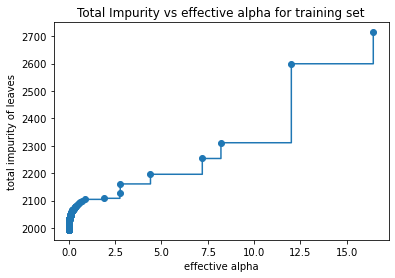

In [63]:
ccp_alphas, impurities = plot_pruning_alphas_vs_impurities(features_train, num_occurrences_train, DecisionTreeRegressor(max_depth = 50), downsampling_factor = 10)

Text(0, 0.5, 'total impurity of leaves')

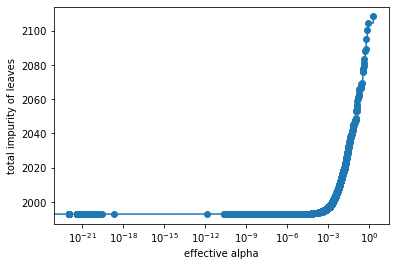

In [92]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-8], impurities[:-8], marker="o", drawstyle="steps-post")
plt.xscale('log')
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
#ax.set_title("Total Impurity vs effective alpha for training set")

In [13]:
results = tree_regr_cv(features_train, num_occurrences_train, [0] + [0] + list(np.geomspace(2e-6, 2, num = 61)))

Training on 20980045 samples with 626 features
Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [37]:
def plot_columns_over_column(df, x_axis_column, y_axis_columns, x_log_scale = True, figsize = (10, 7)):    
    fig, ax = plt.subplots(1, 1, figsize = figsize)
    
    if x_log_scale:
        ax.set(xscale = 'log')
    
    for y in y_axis_columns:        
        ax.errorbar(df[x_axis_column], df[y], df[y.replace('mean', 'std')], label = y.replace('_', ' ').title())
        
    plt.xlabel(x_axis_column.replace('_', ' ').title())
    plt.legend()
    plt.show()
  
df = pd.DataFrame(results.cv_results_)
df = df.drop(columns = ['params'] + [col for col in df.columns if any(word in col for word in ['time', 'split', 'rank'])])
df

,param_ccp_alpha,mean_test_r2,std_test_r2,mean_train_r2,std_train_r2,mean_test_mse,std_test_mse,mean_train_mse,std_train_mse,mean_test_explained_variance,...,mean_train_explained_variance,std_train_explained_variance,mean_test_max_error,std_test_max_error,mean_train_max_error,std_train_max_error,mean_test_median_absolute_error,std_test_median_absolute_error,mean_train_median_absolute_error,std_train_median_absolute_error
0,0,-1.009389,1.408445,0.524112,0.167705,-9083.087671,5033.196246,-2193.841451,2650.073666,-1.009386,...,0.524112,0.167705,-169319.023125,9752.390194,-38419.016593,28795.742825,-2.165622,0.033045,-2.112603,0.052391
1,0.0,-1.076100,1.466379,0.524111,0.167705,-9351.997748,5198.439938,-2193.842242,2650.073240,-1.076096,...,0.524111,0.167705,-169319.023125,9752.390194,-38419.016593,28795.742825,-2.165622,0.033045,-2.112603,0.052391
2,0.0,-1.040302,1.472003,0.524111,0.167705,-9177.196966,5225.993948,-2193.842025,2650.073708,-1.040298,...,0.524111,0.167705,-169319.023125,9752.390194,-38419.016593,28795.742825,-2.165622,0.033045,-2.112603,0.052391
3,0.0,-0.994641,1.420146,0.524112,0.167705,-9003.466384,5073.080688,-2193.840275,2650.073944,-0.994637,...,0.524112,0.167705,-169319.023125,9752.390194,-38419.016593,28795.742825,-2.165622,0.033045,-2.112603,0.052391
4,0.0,-0.992068,1.414635,0.524111,0.167705,-8997.353556,5066.316191,-2193.842471,2650.073581,-0.992065,...,0.524111,0.167705,-169319.023125,9752.390194,-38419.016593,28795.742825,-2.165622,0.033045,-2.112603,0.052391
5,0.000002,-1.066974,1.463296,0.524107,0.167705,-9313.818915,5198.810510,-2193.855973,2650.074424,-1.066970,...,0.524107,0.167705,-169319.023125,9752.390194,-38419.016593,28795.742825,-2.164769,0.032601,-2.113808,0.052560
6,0.00002,-1.064679,1.467924,0.524067,0.167709,-9297.210353,5211.744303,-2193.974807,2650.072608,-1.064675,...,0.524067,0.167709,-169319.023125,9752.390194,-38419.016593,28795.742825,-2.156288,0.040692,-2.112603,0.052391
7,0.0002,-1.013286,1.416729,0.523779,0.167732,-9098.571445,5067.527522,-2194.819435,2650.059498,-1.013282,...,0.523779,0.167732,-169319.023125,9752.390194,-38419.016593,28795.742825,-2.163072,0.032309,-2.154541,0.040252
8,0.002,-1.020457,1.410508,0.521648,0.167930,-9137.776758,5057.799892,-2201.141407,2650.108461,-1.020454,...,0.521648,0.167930,-169319.014071,9752.388437,-38419.016593,28795.742825,-2.192031,0.037603,-2.192031,0.037603
9,0.02,-1.014748,1.412029,0.512966,0.169194,-9110.765947,5060.991111,-2226.713593,2650.081604,-1.014745,...,0.512966,0.169194,-169318.971259,9752.368106,-38419.016593,28795.742825,-2.236279,0.051093,-2.236279,0.051093


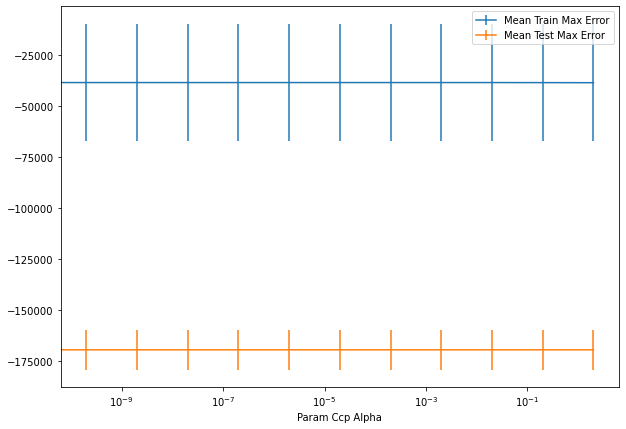

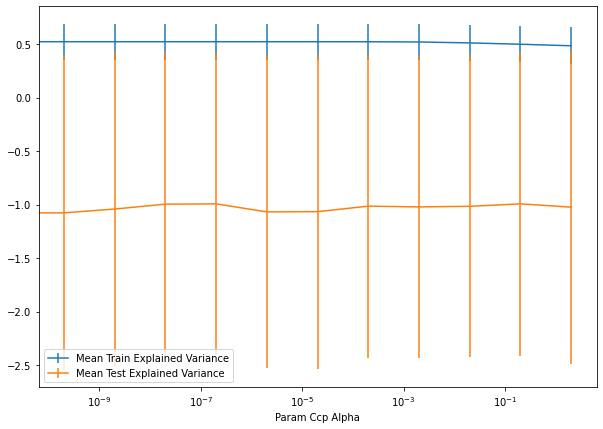

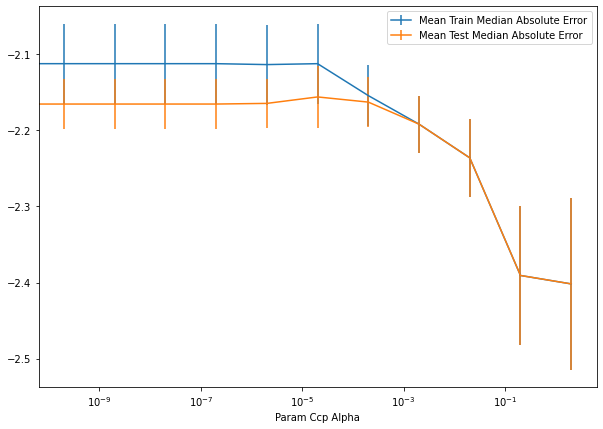

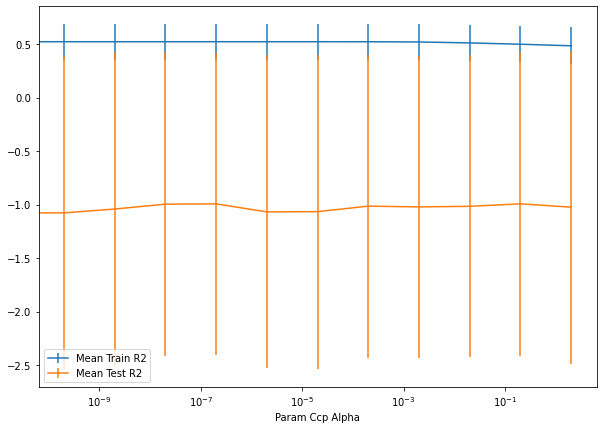

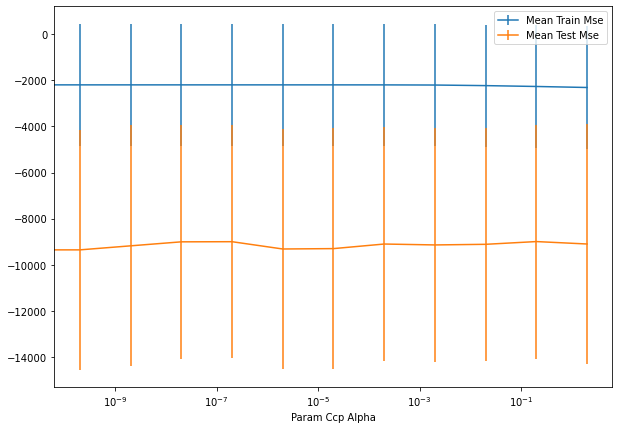

In [39]:
for metric in set([col.replace('mean_', '').replace('std_', '').replace('train_', '').replace('test_', '') for col in df.columns if 'alpha' not in col]):
    plot_columns_over_column(df, 'param_ccp_alpha', [f'mean_train_{metric}', f'mean_test_{metric}'])

In [103]:
from copy import deepcopy

def tree_regr_cv(features, num_occurrences, ccp_alphas, cv_n_splits = 10, verbose = True):
    
    print("Training on {} samples with {} features".format(*features.shape))
    
    folds = list(StratifiedKFold(n_splits = cv_n_splits, shuffle = True).split(np.zeros_like(num_occurrences), get_very_stratifier(num_occurrences, percentile_step = 0.01)))
    
    # Train on single fold, validate on all other folds for computational cost reasons.
    folds = [elem[::-1] for elem in folds]
        
    results = []
    
    # Train on single fold, evaluate on all other folds for computational cost reasons.
    for i, (train_index, val_index) in enumerate(folds):
        if verbose:
            print(f"Starting Fold {i + 1} of {len(folds)}")
            start = time.time()
        
        features_train = features[train_index]
        features_val   = features[val_index]
        num_occurrences_train = num_occurrences[train_index]
        num_occurrences_val   = num_occurrences[val_index]
        
        unpruned_model = DecisionTreeRegressor(max_depth = 50).fit(features_train, num_occurrences_train) 
        
        current_fold_results = {alpha: {'train_scores': {}, 'val_scores': {}} for alpha in ccp_alphas}
        
        for alpha in ccp_alphas:
            model = deepcopy(unpruned_model)
            model.set_params(ccp_alpha = alpha)
            model._prune_tree()
                        
            for key, (X, y) in zip(['train_scores', 'val_scores'], [(features_train, num_occurrences_train), (features_val, num_occurrences_val)]):
                preds = model.predict(X)

                r2 = r2_score(y, preds)
                current_fold_results[alpha][key]['r2']                    = r2
                current_fold_results[alpha][key]['mse']                   = mean_squared_error(y, preds)
                current_fold_results[alpha][key]['explained_variance']    = explained_variance_score(y, preds)
                current_fold_results[alpha][key]['max_error']             = max_error(y, preds)
                current_fold_results[alpha][key]['median_absolute_error'] = median_absolute_error(y, preds)
            
        results.append(current_fold_results)
            
        if verbose:
            print(f"Finished Fold {i + 1} of {len(folds)} in {time.time() - start} seconds")

    return results

In [104]:
results = tree_regr_cv(features_train, num_occurrences_train, [0] + list(np.geomspace(2e-6, 2, num = 61)))

Training on 20980045 samples with 626 features
Starting Fold 1 of 10
Finished Fold 1 of 10 in 1461.7256739139557 seconds
Starting Fold 2 of 10
Finished Fold 2 of 10 in 1273.19286775589 seconds
Starting Fold 3 of 10
Finished Fold 3 of 10 in 1261.067822933197 seconds
Starting Fold 4 of 10
Finished Fold 4 of 10 in 1343.5023143291473 seconds
Starting Fold 5 of 10
Finished Fold 5 of 10 in 1356.3829936981201 seconds
Starting Fold 6 of 10
Finished Fold 6 of 10 in 1325.0664603710175 seconds
Starting Fold 7 of 10
Finished Fold 7 of 10 in 1371.473156929016 seconds
Starting Fold 8 of 10
Finished Fold 8 of 10 in 1361.8231978416443 seconds
Starting Fold 9 of 10
Finished Fold 9 of 10 in 1281.8094654083252 seconds
Starting Fold 10 of 10
Finished Fold 10 of 10 in 1501.3158180713654 seconds


In [105]:
results

[{0: {'train_scores': {'r2': 0.4879543874294294,
    'mse': 603.1694041694182,
    'explained_variance': 0.4879543874294294,
    'max_error': 10999.5,
    'median_absolute_error': 2.069904293843766},
   'val_scores': {'r2': -0.15958167416628322,
    'mse': 6073.775516355158,
    'explained_variance': -0.15958151689871025,
    'max_error': 172569.83169364367,
    'median_absolute_error': 2.168306356316469}},
  2e-06: {'train_scores': {'r2': 0.48794001292481237,
    'mse': 603.1863367652107,
    'explained_variance': 0.4879400129248125,
    'max_error': 10999.5,
    'median_absolute_error': 2.069904293843766},
   'val_scores': {'r2': -0.15958075100150104,
    'mse': 6073.770680908224,
    'explained_variance': -0.15958059894376064,
    'max_error': 172569.83169364367,
    'median_absolute_error': 2.168306356316469}},
  2.5178508235883327e-06: {'train_scores': {'r2': 0.48793682913560577,
    'mse': 603.1900871425045,
    'explained_variance': 0.4879368291356059,
    'max_error': 10999.5,


In [ ]:
# quote_lenght, speaker_age, speaker_gender, speaker_nationality, speaker_occupation, quotation_sentiment, quotation_topic

In [119]:
import itertools
import scipy.sparse

def combine_features(matrix, features_cols_titles, *features):
    dtype = matrix.dtype
    matrix = matrix.tocsc()
    
    feature_vals = [[i for i, val in enumerate(features_cols_titles) if val.startswith(feature)] for feature in features]
    combinations = list(itertools.product(*feature_vals))
        
    new_cols = []
    combinations_str = []
    for i, combination in enumerate(combinations):
        print(f"{i+1} of {len(combinations)}")
        combinations_str.append( "({})".format(', '.join([features_cols_titles[idx] for idx in combination])) )
        new_col = scipy.sparse.coo_matrix( matrix[:, combination].max(axis = 1) )
        new_cols.append( new_col )
    
    matrix = scipy.sparse.hstack([matrix, *new_cols], format = 'csr')
    features_cols_titles = features_cols_titles + combinations_str
    
    return matrix, features_cols_titles
    
m, new_names = combine_features(features_train, features_cols_titles, 'speaker_occupation', 'quotation_sentiment')
m, new_names = combine_features(m, new_names, 'speaker_age', 'speaker_gender', 'speaker_occupation')
m, new_names = combine_features(m, new_names, 'speaker_age', 'speaker_gender', 'speaker_nationality')
m, new_names = combine_features(m, new_names, 'speaker_occupation', 'quotation_topic')
m, new_names = combine_features(m, new_names, 'quotation_topic', 'quotation_sentiment')

69
621
216
13271
1731
